In [1]:
import numpy as np
import matplotlib
import json
import pandas as pd
import os
import re
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from transformers import RobertaTokenizerFast
from nltk import word_tokenize, pos_tag, ngrams
from transformers import RobertaTokenizerFast
from pprint import pprint
from wordcloud import WordCloud
import spacy
from tars.alfred.gen.constants import OBJECTS

In [2]:
bbpe_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def get_num_tokens(text):
    return len(word_tokenize(text))

def get_num_bbpe_tokens(text):
    return len(bbpe_tokenizer(text)["input_ids"])

def freqs_to_df(d, sort=True):
    return pd.DataFrame.from_dict(d, orient="index", columns=["Count"]).sort_values("Count", ascending=False)

def check_obj_in_steps(obj_toks_lower, steps, high_idx):
    check_steps = [] 
    if high_idx >= 1:
        check_steps.append(steps[high_idx - 1])
    if high_idx >= 2:
        check_steps.append(steps[high_idx - 2])
    if high_idx < len(steps):
        check_steps.append(steps[high_idx])
    for step in check_steps:
        step_lower = step.lower()
        for tok in obj_toks_lower:
            if tok in step_lower:
                return 1
    return 0

def task_dirs(splits, data_path):
    for split in splits:
        task_dirs = os.listdir(f'{data_path}/{split}')
        for task_dir in tqdm(task_dirs):
            yield split, task_dir

In [3]:
splits = ["train", "valid_seen", "valid_unseen"]
task_fields = ["task_type", "focus_object", "base_object", "dest_object", "scene"]
data_path = "../tars/alfred/data/json_2.1.0"

In [7]:
# Build table for generating dataset statistics
stats_dict = defaultdict(lambda: [])
action_freqs = defaultdict(lambda: defaultdict(lambda: 0))
bigram_freqs = {"task": defaultdict(lambda: 0), "steps": defaultdict(lambda: 0)}
trigram_freqs = {"task": defaultdict(lambda: 0), "steps": defaultdict(lambda: 0)}

for split, task_dir in task_dirs(splits, data_path):
    task_values = task_dir.split("-")
    for trial_dir in os.listdir("{}/{}/{}".format(data_path, split, task_dir)):
        stats_dict["split"].append(split)
        stats_dict["task_id"].append(trial_dir)

        for j, field in enumerate(task_fields):
            stats_dict[field].append(task_values[j])

        traj_data_file = open("{}/{}/{}/{}/traj_data.json".format(data_path, split, task_dir, trial_dir))
        traj_data = json.load(traj_data_file)
        num_steps_list = []
        num_step_tokens_list = []
        num_task_tokens_list = []
        num_step_bbpe_tokens_list = []
        num_task_bbpe_tokens_list = []

        for directive in traj_data["turk_annotations"]["anns"]:
            task_desc_toks = word_tokenize(directive["task_desc"])
            num_task_tokens_list.append(len(task_desc_toks))
            for bigram in ngrams(task_desc_toks, 2):
                bigram_freqs["task"][bigram] += 1
            for trigram in ngrams(task_desc_toks, 3):
                trigram_freqs["task"][trigram] += 1
            num_steps_list.append(len(directive["high_descs"]))
            total_steps_toks = 0
            for desc in directive["high_descs"]:
                desc_toks = word_tokenize(desc)
                total_steps_toks += len(desc_toks)
                for bigram in ngrams(desc_toks, 2):
                    bigram_freqs["steps"][bigram] += 1
                for trigram in ngrams(desc_toks, 3):
                    trigram_freqs["steps"][trigram] += 1
            num_step_tokens_list.append(total_steps_toks)

            num_step_bbpe_tokens_list.append(sum([get_num_bbpe_tokens(desc) for desc in directive["high_descs"]]))
            num_task_bbpe_tokens_list.append(get_num_bbpe_tokens(directive["task_desc"]))

        stats_dict["steps"].append(np.mean(num_steps_list))
        stats_dict["total_steps_toks"].append(np.mean(num_step_tokens_list))
        stats_dict["total_steps_bbpe_toks"].append(np.mean(num_step_bbpe_tokens_list))
        stats_dict["task_toks"].append(np.mean(num_task_tokens_list))
        stats_dict["task_bbpe_toks"].append(np.mean(num_task_bbpe_tokens_list))
        stats_dict["images"].append(len(traj_data["images"]))
        stats_dict["actions"].append(len(traj_data["plan"]["low_actions"]))
        stats_dict["high_actions"].append(len(traj_data["plan"]["high_pddl"]))        
        stats_dict['total_objects'].append(len(traj_data['scene']['object_poses']))

        nav_count = 0
        interact_count = 0
        mask_cov_per_ac = 0
        interact_step_cov = 0

        for action in traj_data["plan"]["low_actions"]:
            action_freqs[split][action["api_action"]["action"]] += 1
            args = action['discrete_action']['args']
            if "mask" in args:
                obj_name = action["api_action"]["objectId"].split("|")[0]
                obj_toks_lower = [tok.lower() for tok in re.sub('([a-z])([A-Z])', r'\1 \2', obj_name).split()]
                interact_step_cov += np.mean([check_obj_in_steps(obj_toks_lower, directive["high_descs"], action["high_idx"]) for directive in traj_data["turk_annotations"]["anns"]])
                interact_count += 1
                mask_cov_per_ac += sum([l for _, l in args['mask']])
            else:
                nav_count += 1
            
        stats_dict["mask_coverage_per_action"].append(mask_cov_per_ac / (300 * 300 * interact_count))
        stats_dict["nav_actions"].append(nav_count)
        stats_dict["interact_actions"].append(interact_count)
        stats_dict["interact_step_coverage"].append(interact_step_cov / interact_count)

stats_df = pd.DataFrame(stats_dict)
action_df = pd.DataFrame(action_freqs)
task_bigram_df = freqs_to_df(bigram_freqs["task"])
steps_bigram_df = freqs_to_df(bigram_freqs["steps"])
task_trigram_df = freqs_to_df(trigram_freqs["task"])
steps_trigram_df = freqs_to_df(trigram_freqs["steps"])

100%|██████████| 85/85 [00:02<00:00, 32.31it/s]


In [8]:
# Derive some additional columns
stats_df["toks/step"] = stats_df["total_steps_toks"] / stats_df["steps"]
stats_df["bbpe_toks/step"] = stats_df["total_steps_bbpe_toks"] / stats_df["steps"]
stats_df["actions/step"] = stats_df["actions"] / stats_df["steps"]
stats_df["images/action"] = stats_df["images"] / stats_df["actions"]
stats_df["nav/interact"] = stats_df["nav_actions"] / stats_df["interact_actions"]

stats_df = stats_df.round(2)

In [9]:
# Snapshot of metadata table
pd.set_option('display.max_columns', 100)
stats_df

,split,task_id,task_type,focus_object,base_object,dest_object,scene,steps,total_steps_toks,total_steps_bbpe_toks,task_toks,task_bbpe_toks,images,actions,high_actions,total_objects,mask_coverage_per_action,nav_actions,interact_actions,interact_step_coverage,toks/step,bbpe_toks/step,actions/step,images/action,nav/interact
0,train,trial_T20190908_081542_564499,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,84.33,102.33,10.33,12.67,222,40,8,47,0.06,36,4,1.00,12.05,14.62,5.71,5.55,9.00
1,train,trial_T20190908_081608_404049,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,76.67,93.00,12.33,14.67,180,28,8,59,0.06,24,4,1.00,10.95,13.29,4.00,6.43,6.00
2,train,trial_T20190908_081632_840019,pick_and_place_with_movable_recep,ButterKnife,Pan,CounterTop,8,7.0,79.33,93.67,13.00,15.00,213,40,8,46,0.07,36,4,1.00,11.33,13.38,5.71,5.32,9.00
3,train,trial_T20190907_181551_510121,pick_cool_then_place_in_recep,Cup,None,Shelf,1,6.0,95.33,107.67,13.00,15.67,378,79,7,61,0.43,71,8,0.46,15.89,17.94,13.17,4.78,8.88
4,train,trial_T20190907_181654_244229,pick_cool_then_place_in_recep,Cup,None,Shelf,1,6.0,69.33,81.67,8.00,10.00,314,56,7,53,0.44,48,8,0.67,11.56,13.61,9.33,5.61,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,valid_unseen,trial_T20190906_180922_517529,look_at_obj_in_light,Laptop,None,FloorLamp,219,4.0,43.17,53.00,9.33,12.33,153,25,5,26,0.11,22,3,0.78,10.79,13.25,6.25,6.12,7.33
7076,valid_unseen,trial_T20190906_181009_893506,look_at_obj_in_light,Laptop,None,FloorLamp,219,4.0,39.67,49.17,10.50,13.17,174,31,5,27,0.11,28,3,0.83,9.92,12.29,7.75,5.61,9.33
7077,valid_unseen,trial_T20190907_080730_211959,pick_clean_then_place_in_recep,Spatula,None,Drawer,10,6.0,75.67,93.67,11.00,15.00,266,41,7,42,0.05,33,8,0.83,12.61,15.61,6.83,6.49,4.12
7078,valid_unseen,trial_T20190907_080800_275989,pick_clean_then_place_in_recep,Spatula,None,Drawer,10,6.0,86.00,102.67,8.00,11.00,274,45,7,50,0.05,37,8,0.75,14.33,17.11,7.50,6.09,4.62


In [10]:
# Table of action frequencies across splits
action_df

,train,valid_seen,valid_unseen
LookDown,19948,730,776
RotateRight,29447,1122,992
MoveAhead,195054,7540,6877
RotateLeft,27901,1063,1011
PickupObject,12316,470,459
PutObject,11569,438,404
LookUp,12566,489,632
OpenObject,6568,257,291
CloseObject,6637,259,294
ToggleObjectOn,2524,100,132


In [13]:
# Most common trigrams in high-level task descriptions
task_trigram_df[:20]

,Count
"(on, the, counter)",1150
"(the, sink, .)",1142
"(it, on, the)",1022
"(on, the, table)",1022
"(in, the, sink)",978
"(the, counter, .)",815
"(in, the, microwave)",815
"(in, the, fridge)",790
"(it, in, the)",772
"(the, table, .)",746


In [14]:
# Most common trigrams in step-by-step instructions
steps_trigram_df[:20]

,Count
"(Pick, up, the)",18425
"(Turn, around, and)",11767
"(to, the, left)",11126
"(to, the, right)",11084
"(walk, to, the)",10767
"(the, sink, .)",9361
"(to, face, the)",9064
"(and, walk, to)",8722
"(go, to, the)",8616
"(in, front, of)",6828


In [15]:
# Plot frequency of a categorical field. Useful for task_type and maybe objects.
def plot_freq(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    freq_cols = {split:stats_df[stats_df["split"] == split][col].value_counts(normalize=True) for split in splits}
    pd.concat(freq_cols, axis=1).plot.bar(xlabel=col, ylabel="Relative Frequency", **kwargs)

# Plot histogram of a quantitative field. 
def plot_hist(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    axes = stats_df.hist(col, by="split", sharex=True, **kwargs)
    for ax in axes.reshape(-1):
        ax.tick_params(axis="x", which="both", labelbottom=True)
        ax.set_xlabel(col, visible=True)
        ax.set_ylabel("Frequency")

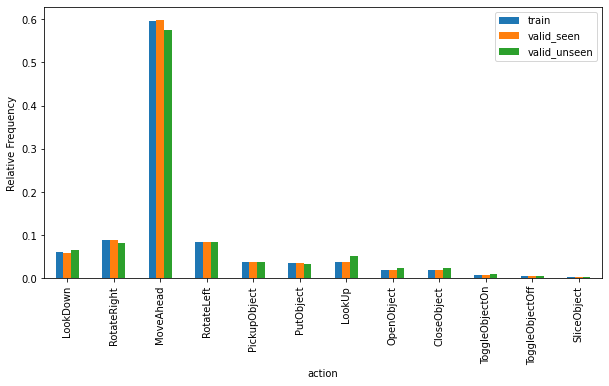

In [16]:
# Plot of action frequencies by split
action_plot = action_df.div(action_df.sum(axis=0)).plot.bar(figsize=(10, 5), xlabel="action", ylabel="Relative Frequency")

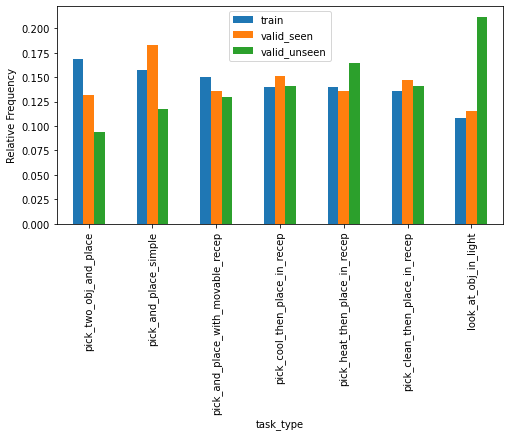

In [17]:
# Plot of task type frequencies by split
plot_freq("task_type", figsize=(8, 4))

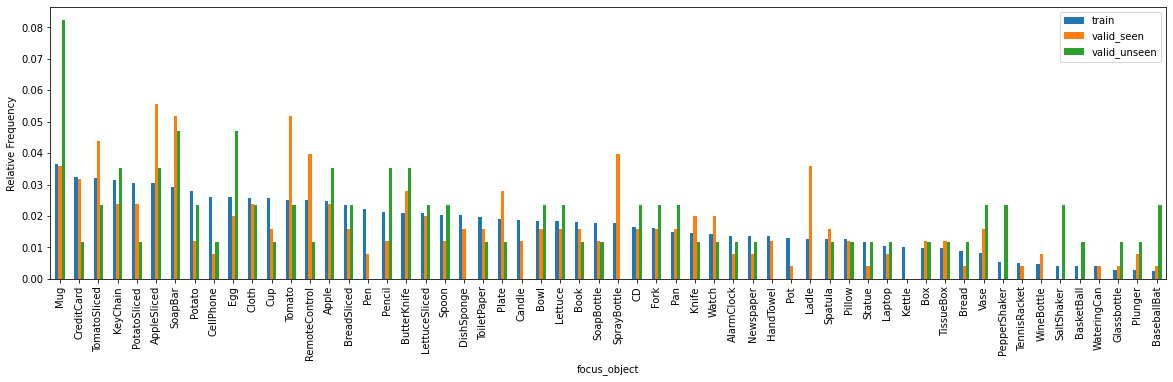

In [18]:
# Plot of focus object frequencies by split
plot_freq("focus_object", figsize=(20, 5))

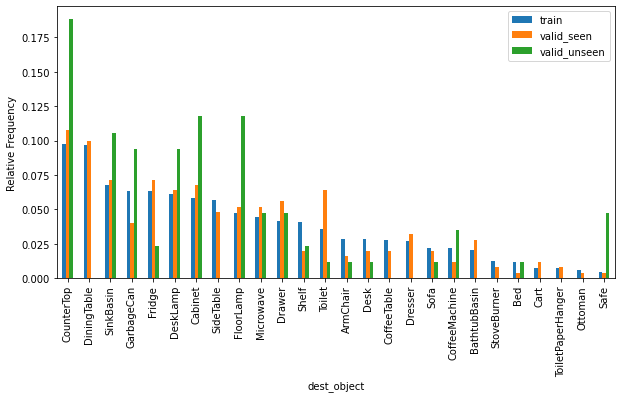

In [19]:
# Plot of destination object frequencies by split
plot_freq("dest_object", figsize=(10, 5))

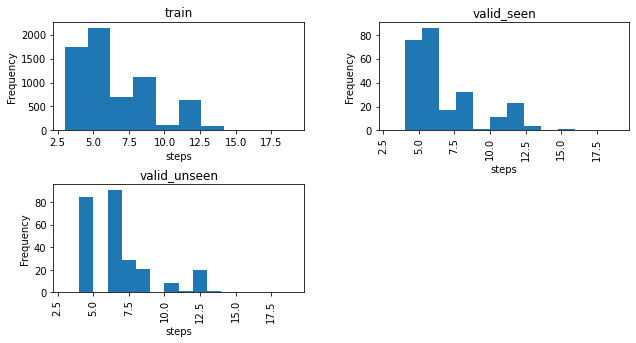

In [20]:
# Histogram per split of number of steps in the language directive
plot_hist("steps", figsize=(10, 5))

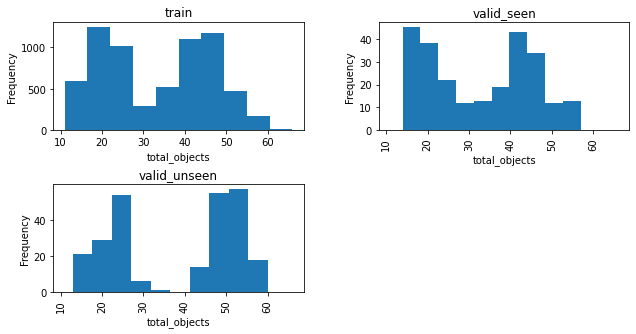

In [21]:
# Histogram per split of total objects in the scene
plot_hist("total_objects", figsize=(10, 5))

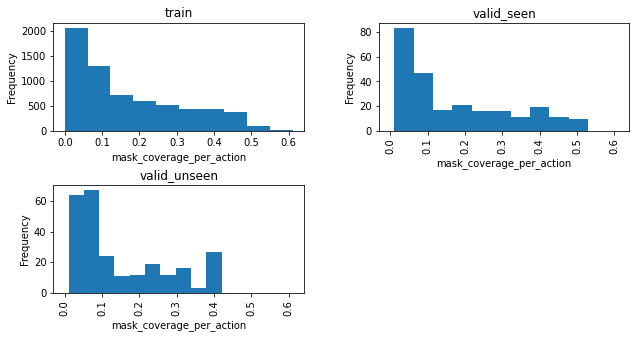

In [22]:
# Histogram per split of mask coverage per action 
# Mask coverage: proportion of image that is covered by the interaction mask, averaged over all interaction actions in the demonstration
plot_hist("mask_coverage_per_action", figsize=(10, 5))

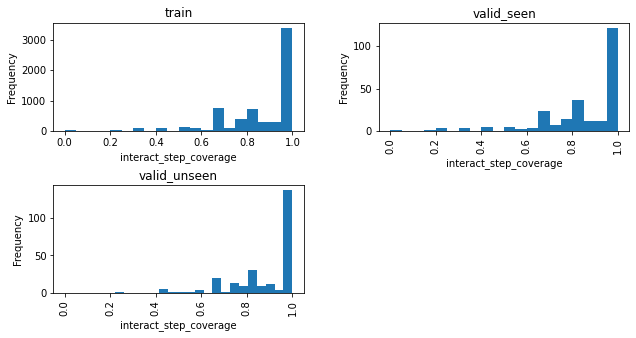

In [24]:
# Histogram per split of interaction step coverage 
# Interaction step coverage: proportion of interaction actions whose object of interest is mentioned in the step-by-step instructions, averaged over all interaction actions and language directives in the demonstration
plot_hist("interact_step_coverage", figsize=(10, 5), bins=20)

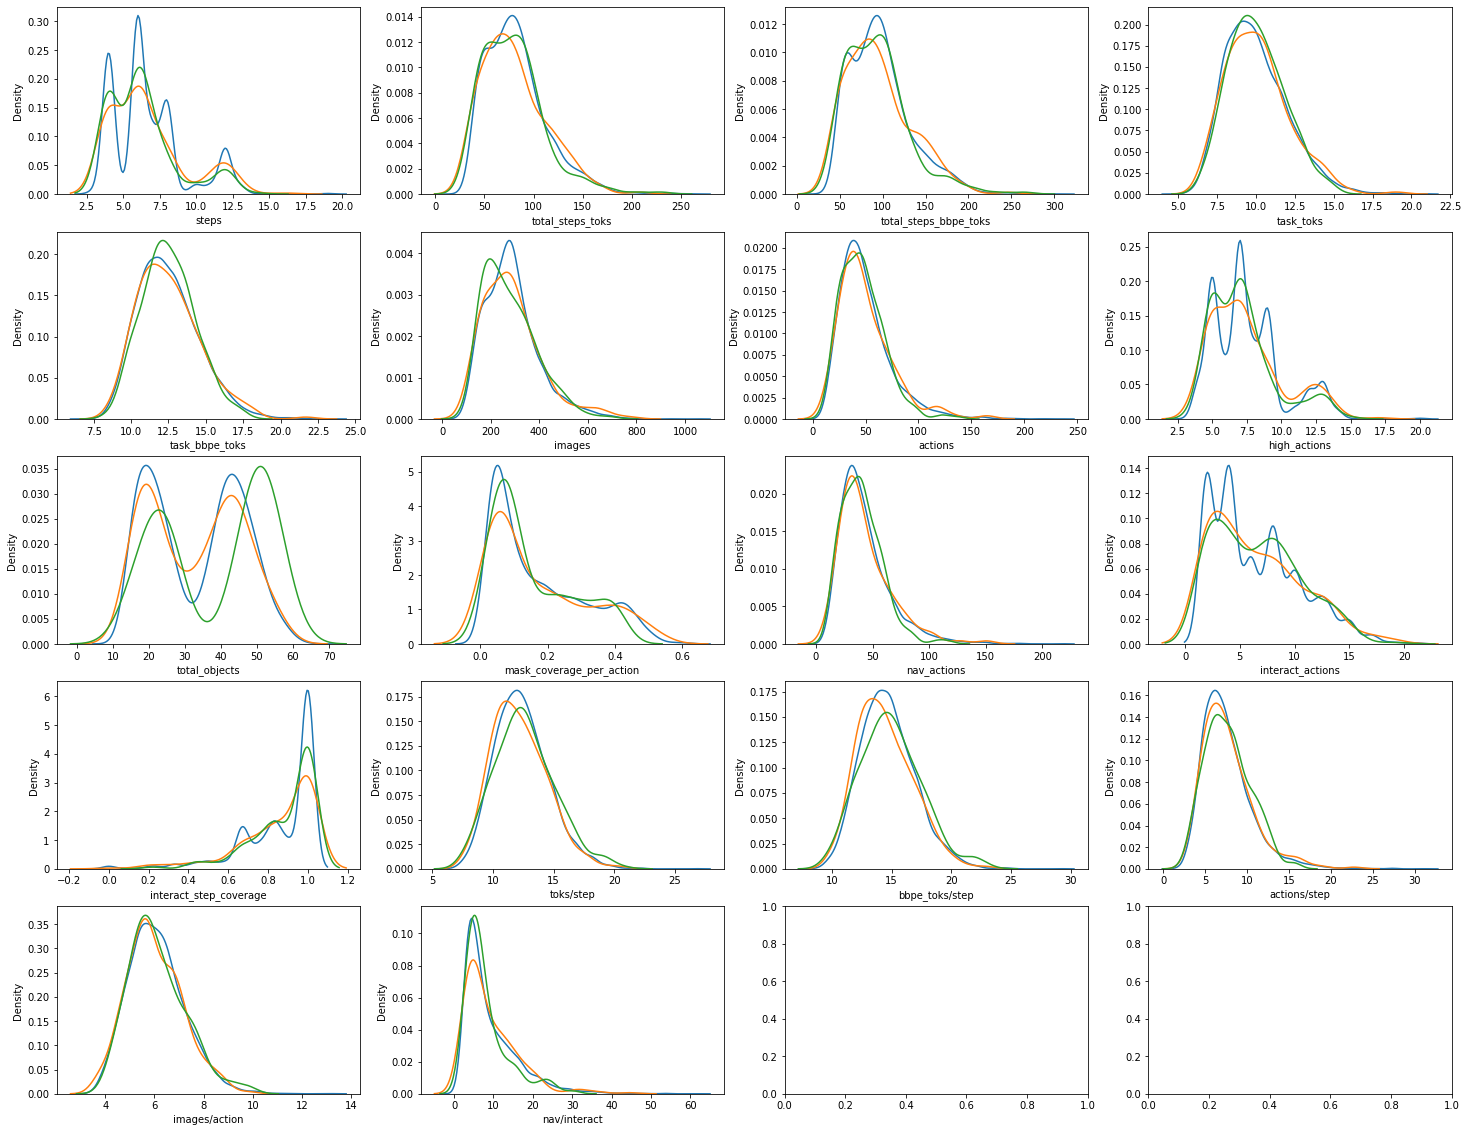

In [25]:
# KDE per split of quantitative fields
# Inspired by https://stackoverflow.com/questions/46045750/python-distplot-with-multiple-distributions

cs = [c for c in stats_df.columns if stats_df[c].dtype != 'O']
splits = stats_df['split'].unique()
df = stats_df[['split'] + cs].melt(['split'], var_name='cols', value_name='vals')
num_cols = 4
num_rows = math.ceil(len(cs) / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 20))

col = 0
for r in range(len(axs)):
    for c in range(len(axs[r])):
        if col >= len(cs):
            break
        for s in splits:
            sns.distplot(stats_df[stats_df['split'] == s][cs[col]], hist=False, rug=False, ax=axs[r][c])
        col += 1


In [26]:
# Mean of quantitative fields
stats_df.groupby('split').mean().round(2)

,steps,total_steps_toks,total_steps_bbpe_toks,task_toks,task_bbpe_toks,images,actions,high_actions,total_objects,mask_coverage_per_action,nav_actions,interact_actions,interact_step_coverage,toks/step,bbpe_toks/step,actions/step,images/action,nav/interact
split,,,,,,,,,,,,,,,,,,
train,6.68,81.88,97.16,10.02,12.48,286.75,49.78,7.51,33.20,0.17,43.34,6.44,0.86,12.39,14.69,7.60,6.08,9.19
valid_seen,6.64,80.20,95.29,10.09,12.52,287.24,50.12,7.47,32.84,0.17,43.60,6.52,0.85,12.18,14.45,7.72,6.02,9.25
valid_unseen,6.27,78.73,93.16,10.04,12.52,277.72,46.98,7.16,38.44,0.15,40.35,6.63,0.88,12.63,14.94,7.72,6.12,8.13


In [28]:
def show_word_cloud(split):
    d = defaultdict(lambda: 0)

    for nouns_dict in stats_df[stats_df['split'] == split]['common_nouns_freq']:
        for k in nouns_dict:
            d[k] += nouns_dict[k]

    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(d)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

show_word_cloud('train')
show_word_cloud('valid_seen')
show_word_cloud('valid_unseen')

In [39]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
common_nouns = defaultdict(lambda:set())
common_nouns_bi = defaultdict(lambda:set())
unk_words = defaultdict(lambda:set())

for split, task_dir in task_dirs(splits, data_path):
    for trial_dir in os.listdir("{}/{}/{}".format(data_path, split, task_dir)):
        traj_data_file = open("{}/{}/{}/{}/traj_data.json".format(data_path, split, task_dir, trial_dir))
        traj_data = json.load(traj_data_file)

        for directive in traj_data["turk_annotations"]["anns"]:
            words = '. '.join(directive['high_descs'] + [directive["task_desc"] + '. '])
            tokens = nlp(words.lower())
            for i, t in enumerate(tokens):
                if t.pos_ == 'NOUN':
                    common_nouns[split].add(t.text)
                    if (i < len(tokens) - 1) and tokens[i + 1].pos_ == 'NOUN':
                        common_nouns_bi[split].add(t.text + '|||' + tokens[i + 1].text)
                if not t.has_vector:
                    unk_words[split].add(t.text)

100%|██████████| 85/85 [00:05<00:00, 15.70it/s]


In [76]:
# print all unknown words in train and validation sets. Note most words are just misspelled, which can probably be corrected
remove_words = defaultdict(lambda: [])
for s in unk_words:
    for unk in unk_words[s]:
        if unk.strip() == '':
            remove_words[s].append(unk)

for s in unk_words:
    unk_words[s] = unk_words[s].difference(remove_words[s])

pprint(dict(unk_words))

{'train': {'\x08put',
           '..',
           '.turn',
           'arouind',
           'bathrub',
           'bathtu',
           'bin.k',
           'bundh',
           'butterknives',
           'cabiniet',
           'cabinst',
           'coffemaker',
           'couterclockwise',
           'coutertop',
           'credt',
           'cubbard',
           'cupl',
           'dispensper',
           'dreser',
           'dress.er',
           'egg.on',
           'elft',
           'fidge',
           'forward.make',
           'forwars',
           'fridge.and',
           'frigde',
           'icrowave',
           'laddle',
           'laddles',
           'lampp',
           'laptop./.',
           'left.q',
           'left.walk',
           'maker.turn',
           'micorwave',
           'microwave.turn',
           'micrwave',
           'micrwoave',
           'mmicrowave',
           'newspsper',
           'nighstand',
           'nigthstand',
           'precool',


In [74]:
synonyms = {}
for ob in tqdm(OBJECTS):
    ob_tokens = nlp(re.sub('([a-z])([A-Z])', r'\1 \2', ob).lower())
    
    sims = {n: ob_tokens.similarity(nlp(n)) for split in common_nouns for n in common_nouns[split]}
    sims.update({' '.join(n.split('|||')): ob_tokens.similarity(nlp(' '.join(n.split('|||')))) for split in common_nouns for n in common_nouns_bi[split]})

    sims = sorted(sims, key=lambda k: -sims[k])
    synonyms[ob_tokens.text] = sims[:3]

100%|██████████| 108/108 [16:27<00:00,  9.14s/it]


In [75]:
# Top 3 synonyms for every object measured by word embedding distance
pprint(synonyms)

{'alarm clock': ['alarm clock', 'alarm clocks', 'alarm'],
 'apple': ['apple', 'slice apple', 'apple slice'],
 'arm chair': ['arm chair', 'arm chairs', 'hand chair'],
 'baseball bat': ['baseball bat', 'baseball bats', 'baseball'],
 'basket ball': ['basket ball', 'ball', 'basket'],
 'bathtub': ['bathtub', 'bathroom tub', 'bathtub ledge'],
 'bathtub basin': ['tub basin', 'toilet basin', 'sink basin'],
 'bed': ['bed', 'bunk bed', 'hand bed'],
 'blinds': ['blinds', 'curtains', 'curtain'],
 'book': ['book', 'place book', 'books'],
 'boots': ['boots', 'leather', 'jacket'],
 'bowl': ['bowl', 'place bowl', 'round bowl'],
 'box': ['box', 'box box', 'box boxes'],
 'bread': ['bread', 'bread loaf', 'loaf bread'],
 'butter knife': ['butter knife', 'butter knives', 'bread knife'],
 'cabinet': ['cabinet', 'cabinet coutertop', 'cabinet cabinet'],
 'candle': ['candle', 'candles', 'candle stick'],
 'cart': ['cart', 'rack cart', 'towel cart'],
 'cd': ['cd', 'place cd', 'move cd'],
 'cell phone': ['cell ph